# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


/tmp/ipykernel_27418/384002432.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('Data/Training/pair_features_1_pairs1_300_120.csv')
df.head()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,UNH,2001-02-09 00:00:00,14.962,14.562,9462800.000,11.819,COP,21.288,20.994,8208926.000,10.112,1.706,1.574,0.787,1.430,0.749,0.000,1.615,0.413
1,UNH,2001-02-12 00:00:00,15.123,14.507,10798000.000,11.934,COP,21.600,21.345,10666435.000,10.219,1.714,1.570,0.783,1.469,0.742,0.000,1.621,0.415
2,UNH,2001-02-13 00:00:00,15.188,14.632,6012400.000,11.827,COP,21.798,21.345,7761867.000,10.368,1.459,1.565,0.779,1.516,0.709,0.000,1.635,0.414
3,UNH,2001-02-14 00:00:00,15.017,14.222,7660000.000,11.506,COP,21.783,21.295,12059819.000,10.259,1.247,1.559,0.774,1.549,0.678,0.000,1.655,0.405
4,UNH,2001-02-15 00:00:00,14.700,14.060,11206400.000,11.354,COP,21.650,21.250,10194190.000,10.176,1.179,1.552,0.768,1.580,0.642,0.000,1.658,0.401


In [3]:
df['pnls'] = df['pnls']*100.0
# df = df[df.pnls != 0]

In [4]:
total_days = df.Date.nunique()
total_days

5738

In [5]:
# df.dropna()

In [6]:
df.pnls.describe()

count   5738.000
mean       0.203
std        2.630
min      -13.353
25%        0.000
50%        0.000
75%        0.521
max       25.707
Name: pnls, dtype: float64

## Technical Indicators

In [7]:
df

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,UNH,2001-02-09 00:00:00,14.962,14.562,9462800.000,11.819,COP,21.288,20.994,8208926.000,10.112,1.706,1.574,0.787,1.430,0.749,0.000,1.615,0.413
1,UNH,2001-02-12 00:00:00,15.123,14.507,10798000.000,11.934,COP,21.600,21.345,10666435.000,10.219,1.714,1.570,0.783,1.469,0.742,0.000,1.621,0.415
2,UNH,2001-02-13 00:00:00,15.188,14.632,6012400.000,11.827,COP,21.798,21.345,7761867.000,10.368,1.459,1.565,0.779,1.516,0.709,0.000,1.635,0.414
3,UNH,2001-02-14 00:00:00,15.017,14.222,7660000.000,11.506,COP,21.783,21.295,12059819.000,10.259,1.247,1.559,0.774,1.549,0.678,0.000,1.655,0.405
4,UNH,2001-02-15 00:00:00,14.700,14.060,11206400.000,11.354,COP,21.650,21.250,10194190.000,10.176,1.179,1.552,0.768,1.580,0.642,0.000,1.658,0.401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,UNH,2023-11-24 00:00:00,547.590,542.810,1135000.000,545.240,COP,116.570,114.860,2159200.000,114.672,430.568,388.372,19.988,420.102,6.477,1.261,425.091,13.099
5734,UNH,2023-11-27 00:00:00,550.890,541.530,2675800.000,541.742,COP,115.130,113.360,5289500.000,113.987,427.755,388.444,20.092,421.164,5.840,1.261,423.796,14.019
5735,UNH,2023-11-28 00:00:00,545.820,540.070,2859300.000,538.692,COP,115.980,114.480,3469100.000,114.166,424.527,388.497,20.166,421.817,5.414,1.261,422.826,14.594
5736,UNH,2023-11-29 00:00:00,541.860,528.650,4550000.000,533.161,COP,115.560,113.320,6065300.000,113.163,419.998,388.535,20.214,421.998,5.281,1.261,422.288,14.884


### Beta

In [8]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [9]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

2

### Single Ticker Features

In [10]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls', 'actual_abs_spread',
       'actual_abs_spread_std'],
      dtype='object')

In [11]:
df.sort_values('Date')

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,UNH,2001-02-09 00:00:00,14.962,14.562,9462800.000,11.819,COP,21.288,20.994,8208926.000,10.112,1.706,1.574,0.787,1.430,0.749,0.000,1.615,0.413
1,UNH,2001-02-12 00:00:00,15.123,14.507,10798000.000,11.934,COP,21.600,21.345,10666435.000,10.219,1.714,1.570,0.783,1.469,0.742,0.000,1.621,0.415
2,UNH,2001-02-13 00:00:00,15.188,14.632,6012400.000,11.827,COP,21.798,21.345,7761867.000,10.368,1.459,1.565,0.779,1.516,0.709,0.000,1.635,0.414
3,UNH,2001-02-14 00:00:00,15.017,14.222,7660000.000,11.506,COP,21.783,21.295,12059819.000,10.259,1.247,1.559,0.774,1.549,0.678,0.000,1.655,0.405
4,UNH,2001-02-15 00:00:00,14.700,14.060,11206400.000,11.354,COP,21.650,21.250,10194190.000,10.176,1.179,1.552,0.768,1.580,0.642,0.000,1.658,0.401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,UNH,2023-11-24 00:00:00,547.590,542.810,1135000.000,545.240,COP,116.570,114.860,2159200.000,114.672,430.568,388.372,19.988,420.102,6.477,1.261,425.091,13.099
5734,UNH,2023-11-27 00:00:00,550.890,541.530,2675800.000,541.742,COP,115.130,113.360,5289500.000,113.987,427.755,388.444,20.092,421.164,5.840,1.261,423.796,14.019
5735,UNH,2023-11-28 00:00:00,545.820,540.070,2859300.000,538.692,COP,115.980,114.480,3469100.000,114.166,424.527,388.497,20.166,421.817,5.414,1.261,422.826,14.594
5736,UNH,2023-11-29 00:00:00,541.860,528.650,4550000.000,533.161,COP,115.560,113.320,6065300.000,113.163,419.998,388.535,20.214,421.998,5.281,1.261,422.288,14.884


In [12]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls', 'actual_abs_spread',
       'actual_abs_spread_std'],
      dtype='object')

In [13]:
label = 'actual_abs_spread'
exclude = ['pnls', 'High_P1', 'High_P2', 'Low_P1', 'Low_P2', 'abs_spread', 'abs_spread_mean', 'abs_spread_std', 'actual_abs_spread_std']
X = df
y = df[label]

X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
X = X.drop(exclude, axis=1)

In [14]:
X = X.dropna()
X['abs_spread_log_mean_MA'] = np.log(X['abs_spread_mean_MA'])
X['abs_spread_log_std_mean_MA'] = np.log(X['abs_spread_std_MA'])
X = X.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)
X

,Close_P1,Close_P2,abs_spread_log_mean_MA,abs_spread_log_std_mean_MA
0,11.819,10.112,0.358,-0.289
1,11.934,10.219,0.385,-0.298
2,11.827,10.368,0.416,-0.344
3,11.506,10.259,0.438,-0.389
4,11.354,10.176,0.458,-0.443
...,...,...,...,...
5733,545.240,114.672,6.040,1.868
5734,541.742,113.987,6.043,1.765
5735,538.692,114.166,6.045,1.689
5736,533.161,113.163,6.045,1.664


In [15]:
y = np.log(y)
y.describe()

count   5738.000
mean       3.190
std        1.837
min       -1.394
25%        2.002
50%        2.692
75%        5.093
max        6.081
Name: actual_abs_spread, dtype: float64

## Train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [17]:
print(df.loc[X_train.index].Date.min(),df.loc[X_train.index].Date.max())

2001-02-09 00:00:00 2019-05-10 00:00:00


In [18]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-05-13 00:00:00 2021-08-19 00:00:00


In [19]:
print(df.loc[X_test.index].Date.min(),df.loc[X_test.index].Date.max())

2021-08-20 00:00:00 2023-11-30 00:00:00


## LSTM Model

In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.lstm = LSTM(512, input_shape=self.shape, dropout=0.2, return_sequences = True)
        self.dropout = Dropout(0.2)
        self.dense = Dense(1)

    def call(self, x):
        x = self.lstm(x)
#         x = self.dropout(x)
        x = self.dense(x)
        return x

2024-03-20 06:49:48.092328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 06:49:48.831004: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])).astype(np.float32)
testX = np.reshape(X_test, ( X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [22]:
trainX.shape

(4590, 1, 4)

In [23]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,\
                                            min_delta=0.001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[0], 1, trainX.shape[1]))
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX, 
                    y_train,
                    validation_data=(valX, y_val), 
                    epochs=20, 
                    batch_size=32,
                    verbose=1, 
                    callbacks=callback,
                    shuffle=False)       

Epoch 1/20


2024-03-20 06:49:49.662334: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


144/144 [==============================] - 4s 14ms/step - loss: 0.9664 - mae: 0.9664 - val_loss: 0.2808 - val_mae: 0.2808
Epoch 2/20
144/144 [==============================] - 2s 12ms/step - loss: 0.5915 - mae: 0.5915 - val_loss: 0.2869 - val_mae: 0.2869
Epoch 3/20
144/144 [==============================] - 2s 12ms/step - loss: 0.5627 - mae: 0.5627 - val_loss: 0.2962 - val_mae: 0.2962
Epoch 4/20
144/144 [==============================] - 2s 12ms/step - loss: 0.5400 - mae: 0.5400 - val_loss: 0.2458 - val_mae: 0.2458
Epoch 5/20
144/144 [==============================] - 2s 12ms/step - loss: 0.5023 - mae: 0.5023 - val_loss: 0.2191 - val_mae: 0.2191
Epoch 6/20
144/144 [==============================] - 2s 12ms/step - loss: 0.4915 - mae: 0.4915 - val_loss: 0.1800 - val_mae: 0.1800
Epoch 7/20
144/144 [==============================] - 2s 12ms/step - loss: 0.4770 - mae: 0.4770 - val_loss: 0.2410 - val_mae: 0.2410
Epoch 8/20
144/144 [==============================] - 2s 12ms/step - loss: 0.480

In [24]:
lstm_model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  1058816   
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 dense (Dense)               multiple                  513       
                                                                 
Total params: 1059329 (4.04 MB)
Trainable params: 1059329 (4.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


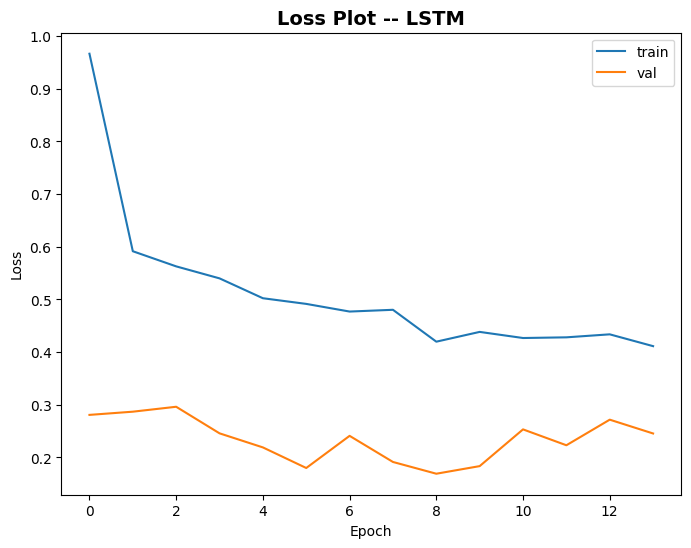

In [25]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
inference_result = lstm_model.predict(testX).flatten()

18/18 [==============================] - 0s 2ms/step


count   574.000
mean      5.965
std       0.060
min       5.797
25%       5.924
50%       5.959
75%       6.009
max       6.081
Name: actual_abs_spread, dtype: float64

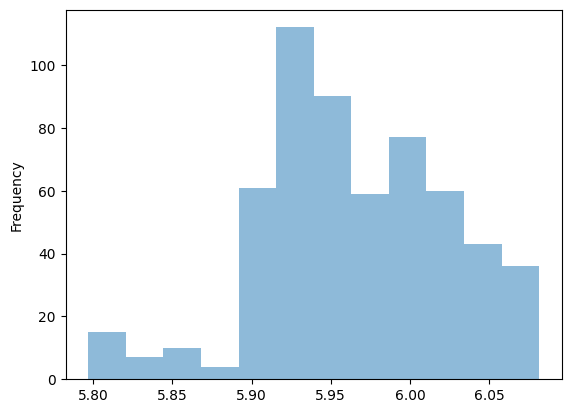

In [27]:
y_test.plot.hist(bins=12, alpha=0.5)
y_test.describe()

count   574.000
mean      5.416
std       0.026
min       5.384
25%       5.397
50%       5.405
75%       5.429
max       5.491
dtype: float64

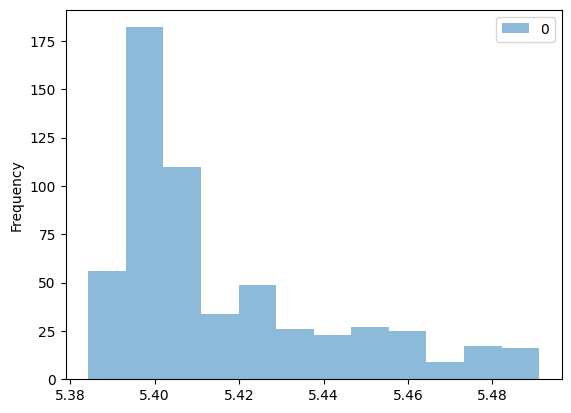

In [28]:
pd.DataFrame(inference_result).plot.hist(bins=12, alpha=0.5)
pd.Series(inference_result).describe()

In [29]:
lstm_mae = (inference_result[:len(y_test)] - y_test).abs().mean()
lstm_mae

0.5483307252456344

In [30]:
inference_result

array([5.491041 , 5.4848633, 5.4825273, 5.4791145, 5.479132 , 5.4770384,
       5.477868 , 5.4779797, 5.4803567, 5.4802933, 5.4805226, 5.48007  ,
       5.4779162, 5.476766 , 5.4706554, 5.4734316, 5.4735985, 5.471495 ,
       5.4712806, 5.473959 , 5.473259 , 5.46799  , 5.4586678, 5.4546623,
       5.450741 , 5.445172 , 5.437868 , 5.4385595, 5.4326   , 5.4277716,
       5.420476 , 5.4243627, 5.424732 , 5.43254  , 5.4262094, 5.4263496,
       5.4265966, 5.427199 , 5.436282 , 5.4402313, 5.437127 , 5.4348025,
       5.4394827, 5.447748 , 5.4488297, 5.446928 , 5.448579 , 5.453885 ,
       5.453062 , 5.4578085, 5.453876 , 5.456975 , 5.4608192, 5.458919 ,
       5.452429 , 5.454947 , 5.456367 , 5.4613647, 5.4622345, 5.462508 ,
       5.4566374, 5.4559164, 5.4571543, 5.455252 , 5.4582376, 5.450598 ,
       5.451146 , 5.450027 , 5.4532747, 5.458602 , 5.45957  , 5.462182 ,
       5.4575295, 5.4607515, 5.462392 , 5.4601727, 5.4638786, 5.4708195,
       5.4710646, 5.4778004, 5.4794836, 5.4874177, 

In [31]:
mae = lstm_mae / y_test.abs().mean()
mae

0.09193098000958476

In [32]:
# Generate the PNL from predicted spread
from pair_trading_foundations.data_generation import ExecutePairTrading

BacktestData = df.loc[X_test.index]

samples = BacktestData
samples = samples.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
samples = samples.drop(exclude,axis=1)
samples['abs_spread_log_mean_MA'] = np.log(samples.abs_spread_mean_MA)
samples['abs_spread_log_std_mean_MA'] = np.log(samples.abs_spread_std_MA)
samples = samples.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)

model_input = np.reshape(samples, (samples.shape[0], 1, samples.shape[1])).astype(np.float32)
inference_result = lstm_model.predict(model_input).flatten()
BacktestData['pred_abs_spread'] = np.exp(inference_result)
BacktestData['diff_abs_spread'] = BacktestData['pred_abs_spread'] - BacktestData['abs_spread_mean_MA']
BacktestData['z_score'] = (np.log(BacktestData['pred_abs_spread']) / BacktestData['abs_spread_std_MA'])
BacktestData = BacktestData.reset_index()
BacktestData

pnls = []
entry_signal = 2
exit_signal = 0.5
test_len = 20
for idx in range(BacktestData.shape[0]):
    if (idx > BacktestData.shape[0]-test_len-1):
        pnls.append(np.nan)
    else:
        current_row = BacktestData.loc[idx]
        result = ExecutePairTrading(current_row.pred_abs_spread,   # Use predicted spread
                                    current_row.abs_spread_std_MA, # Use current std deviation
                                    entry_signal=entry_signal,
                                    exit_signal=exit_signal
                                ).execute(
                                    # Forward window
                                    vec1=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P1'].values,
                                    vec2=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P2'].values,
                                    dates=BacktestData.loc[(idx+1):(idx+test_len)]['Date'].values,
                                    base_fund=100,
                                )

        pnls.append(result.final_pl_pct)

BacktestData['pnls'] = pnls
BacktestData = BacktestData.dropna()
BacktestData

strategy = BacktestData.loc[(abs(BacktestData['z_score']) > 0.95)]
strategy

18/18 [==============================] - 0s 2ms/step


,index,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,...,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std,pred_abs_spread,diff_abs_spread,z_score
19,5183,UNH,2021-09-17 00:00:00,421.090,414.970,4534200.000,407.366,COP,59.910,58.780,...,304.361,34.029,353.879,5.410,0.131,329.635,10.951,238.402,-115.477,1.012
20,5184,UNH,2021-09-20 00:00:00,419.300,408.720,2799800.000,400.133,COP,58.010,56.300,...,304.685,33.984,352.933,4.484,0.113,329.425,10.622,238.235,-114.698,1.221
21,5185,UNH,2021-09-21 00:00:00,418.780,412.210,2382200.000,399.784,COP,59.830,57.720,...,304.979,33.960,352.169,4.255,0.086,329.286,10.418,236.983,-115.186,1.285
22,5186,UNH,2021-09-22 00:00:00,412.000,404.940,3629400.000,396.255,COP,62.890,60.210,...,305.267,33.889,351.218,4.746,0.063,329.944,11.437,234.784,-116.434,1.150
23,5187,UNH,2021-09-23 00:00:00,414.850,407.510,2681600.000,395.605,COP,64.120,62.250,...,305.539,33.823,350.374,5.499,0.030,331.112,13.252,233.846,-116.528,0.992
62,5226,UNH,2021-11-17 00:00:00,453.960,448.730,2281500.000,435.279,COP,73.930,71.730,...,317.192,33.400,373.464,5.200,-0.057,380.802,17.496,234.429,-139.035,1.050
63,5227,UNH,2021-11-18 00:00:00,452.810,447.110,2073800.000,435.783,COP,73.210,71.610,...,317.560,33.368,373.877,4.466,-0.063,382.891,18.506,233.984,-139.893,1.222
64,5228,UNH,2021-11-19 00:00:00,449.450,439.500,3536100.000,426.601,COP,71.300,69.410,...,317.885,33.336,373.690,4.830,-0.077,385.133,18.712,234.683,-139.007,1.130
65,5229,UNH,2021-11-22 00:00:00,443.750,437.390,2598700.000,424.216,COP,72.830,69.610,...,318.200,33.274,373.301,5.671,-0.068,387.673,18.416,232.897,-140.404,0.961
245,5409,UNH,2022-08-11 00:00:00,538.630,529.670,3006200.000,521.706,COP,101.320,97.520,...,377.948,32.666,435.688,5.419,0.064,421.659,13.118,226.850,-208.838,1.001


count   40.000
mean     0.033
std      0.049
min     -0.077
25%      0.013
50%      0.038
75%      0.063
max      0.131
Name: pnls, dtype: float64

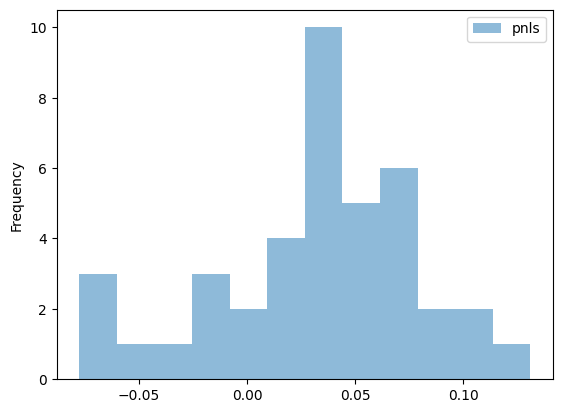

In [33]:
pd.DataFrame(strategy.pnls).plot.hist(bins=12, alpha=0.5)
pd.Series(strategy.pnls).describe()

In [34]:
# Normality test

from scipy.stats import shapiro
# normality test
stat, p = shapiro(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.845, p=0.000
Sample does not look Gaussian (reject H0)


In [35]:
# D’Agostino’s K^2 Test
from scipy.stats import normaltest
# normality test
stat, p = normaltest(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=93.381, p=0.000
Sample does not look Gaussian (reject H0)


In [36]:
# Anderson-Darling Test
from scipy.stats import anderson
result = anderson(inference_result)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
if result.statistic < result.critical_values[i]:
    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
else:
    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 33.124
1.000: 1.085, data does not look normal (reject H0)
